## A Minimal "MultiWormTracker"

I don't like MATLAB, so I wrote this.

Given an input `.avi` file, this notebook will output the position for each worm at each frame in a `.csv` file. Does not extract any other features or extrapolate between frames where a worm is lost. Edit the parameters in ALL CAPS to fit to your data.

### 1 Imports functions from the `mwt.py` script, which has to be in the same directory as this notebook

The script requires a couple non-standard packages which can be installed at once using `conda install joblib scikit-image ffmpeg`

In [1]:
from mwt import *

### 2 Locate files and makes a scratch directory [EDIT]

The notebook requires a scratch directory with a lot of storage that will be filled with the `.avi` file converted into `.tif` for each individual frame. This scratch directory should have up to 75 GB free (51 GB used for a 1h 30' 3000x1500px recording) (36 GB used for a 45' 2500x2400px recording)

In [2]:
#filenames with spaces don't quite work, so please replace with underscores first
INPUT_AVI = '/Users/albertwang/Desktop/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5.avi'
SCRATCH_PATH = '/Volumes/SCRATCH'
OUTPUT_PATH = '/Users/albertwang/Desktop'

scratch_dir = make_scratch_dir(INPUT_AVI, SCRATCH_PATH)
scratch_dir

'/Volumes/SCRATCH/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5-scratch/'

### 3 Makes a mask by getting one frame for each minute of the recording and getting the median of all those frames (<2' for a 30' 2300x2300px recording)

Input #0, avi, from '/Users/albertwang/Desktop/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5.avi':
  Metadata:
    date            : 1691891265:701589
  Duration: 00:29:59.66, start: 0.000000, bitrate: 15348 kb/s
  Stream #0:0: Video: mjpeg (Baseline) (MJPG / 0x47504A4D), yuvj444p(pc, bt470bg/unknown/unknown), 2304x2304 [SAR 1:1 DAR 1:1], 15344 kb/s, 3 fps, 3 tbr, 3 tbn
Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> tiff (native))
Press [q] to stop, [?] for help
[swscaler @ 0x1600e0000] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to '/Volumes/SCRATCH/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5-scratch/minute/%06d.tif':
  Metadata:
    date            : 1691891265:701589
    encoder         : Lavf61.7.100
  Stream #0:0: Video: tiff, gray(pc, progressive), 2304x2304 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 3 fps, 3 tbn
      Metadata:
        encoder         : Lavc61.19.100 tiff
[out#0/image2 @ 0x60000253454

CPU times: user 2.12 s, sys: 377 ms, total: 2.5 s
Wall time: 1min 11s


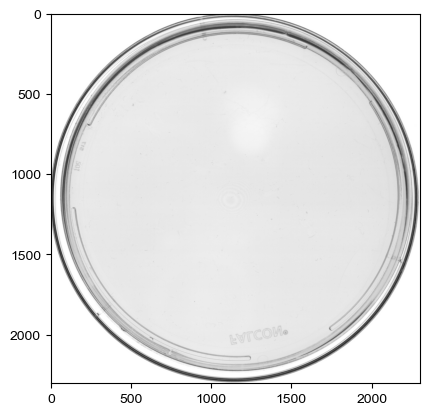

In [3]:
%%time

mask = make_mask(INPUT_AVI, scratch_dir)

### 4 Tries out threshold parameters (check that this worked afterward) (<1' for a 30' 2300x2300px recording)

The threshold parameter varies for different videos depending on the overall brightness of the plate, this funtion will guess thresholds within the guess range and apply them on the minute `.tif` frames from the mask determination

CPU times: user 16.6 s, sys: 4.87 s, total: 21.5 s
Wall time: 22.9 s


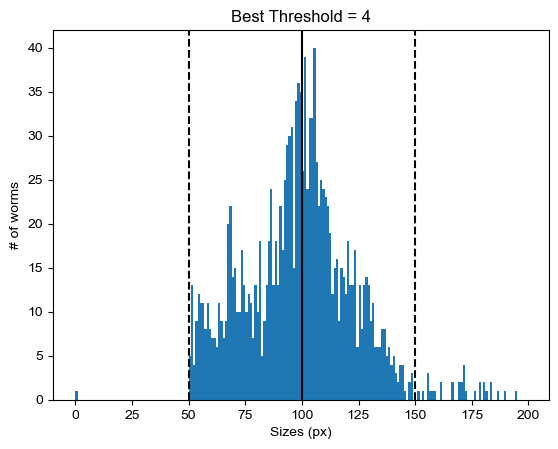

In [4]:
%%time
THRESHOLD_GUESSES = range(2, 11)
SIZE_RANGE = (50, 150)

best_threshold = guess_threshold(scratch_dir, mask, threshold_guesses=THRESHOLD_GUESSES, size_range=SIZE_RANGE)

### 5 Convert `.avi` to `.tif` with `ffmpeg` (<2' for a 30' 2300x2300px recording)

In [5]:
%%time

convert_to_tif(INPUT_AVI, scratch_dir)

Input #0, avi, from '/Users/albertwang/Desktop/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5.avi':
  Metadata:
    date            : 1691891265:701589
  Duration: 00:29:59.66, start: 0.000000, bitrate: 15348 kb/s
  Stream #0:0: Video: mjpeg (Baseline) (MJPG / 0x47504A4D), yuvj444p(pc, bt470bg/unknown/unknown), 2304x2304 [SAR 1:1 DAR 1:1], 15344 kb/s, 3 fps, 3 tbr, 3 tbn
Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> tiff (native))
Press [q] to stop, [?] for help
[swscaler @ 0x130710000] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to '/Volumes/SCRATCH/2023-08-12-01_nlp76CoChR_historical_oneASHStim10minslater_c5-scratch/tif/%06d.tif':
  Metadata:
    date            : 1691891265:701589
    encoder         : Lavf61.7.100
  Stream #0:0: Video: tiff, gray(pc, progressive), 2304x2304 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 3 fps, 3 tbn
      Metadata:
        encoder         : Lavc61.19.100 tiff
frame= 5374 fps= 75 q=-0.0 size=

Frames converted: 5400
CPU times: user 73.8 ms, sys: 30.5 ms, total: 104 ms
Wall time: 1min 12s


[out#0/image2 @ 0x600003098300] video:21566444KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame= 5400 fps= 75 q=-0.0 Lsize=N/A time=00:30:00.00 bitrate=N/A speed=24.8x    


### 6 Detect worms for each frame (<3' for a 30' 2300x2300px recording)

CPU times: user 18.6 s, sys: 2.2 s, total: 20.8 s
Wall time: 2min 33s


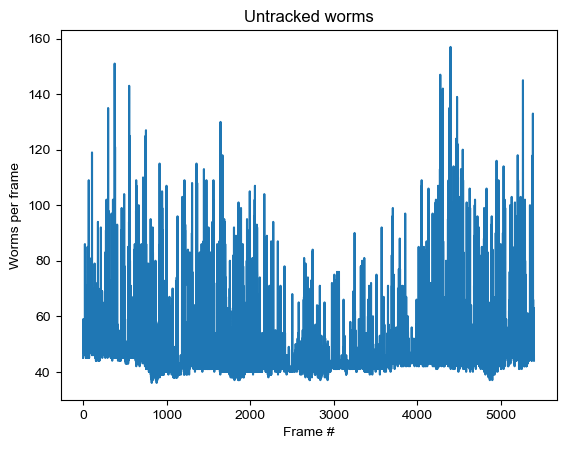

In [6]:
%%time
ECCENTRICITY_RANGE = (0.5, 1)

detect_worms(scratch_dir, mask, best_threshold, size_range=SIZE_RANGE, ecc_range=ECCENTRICITY_RANGE)

### 7 Link worms between each frame into a `.csv` (<1' for a 30' 2300x2300px recording)

CPU times: user 2.18 s, sys: 446 ms, total: 2.62 s
Wall time: 29.7 s


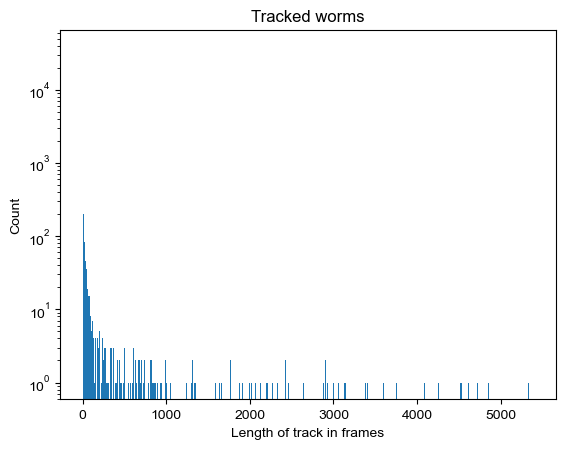

In [7]:
%%time
MAX_SPEED = 0.6

link_worms(scratch_dir, max_speed=MAX_SPEED)

### 8 Trim out short tracks

Removes tracks that are too short and move too little

CPU times: user 768 ms, sys: 42.1 ms, total: 810 ms
Wall time: 843 ms


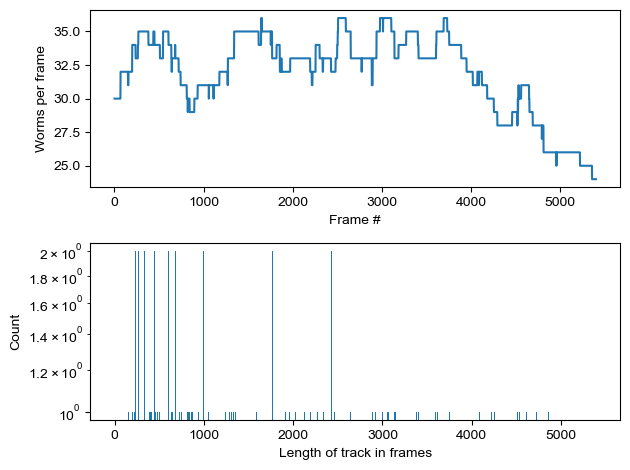

In [8]:
MIN_SECS_TRACKED = 30
MIN_AREA_TRACKED = 2

trim_csv(scratch_dir, min_secs_tracked=MIN_SECS_TRACKED, min_area_tracked=MIN_AREA_TRACKED)

### 9 One final visualization

CPU times: user 1.68 s, sys: 185 ms, total: 1.87 s
Wall time: 1.88 s


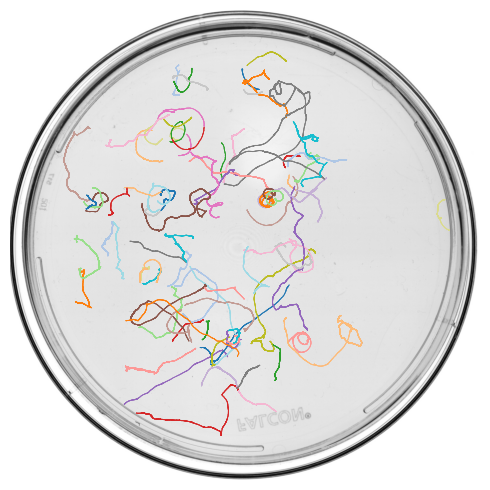

In [9]:
plot_tracks(scratch_dir, mask)

### 10 Copy all files to the output folder (must run this cell to save!)

In [10]:
save_output(INPUT_AVI, scratch_dir, OUTPUT_PATH, best_threshold, SIZE_RANGE,
            ECCENTRICITY_RANGE, MAX_SPEED, MIN_SECS_TRACKED, MIN_AREA_TRACKED)

CPU times: user 767 μs, sys: 2.01 ms, total: 2.78 ms
Wall time: 51.2 ms


### 11 Delete the scratch directory on your own

In [11]:
#os.system(f'rm -rf {scratch_dir}')